In [90]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201, VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [91]:
image_path = '/kaggle/input/flickr8k/images'

In [92]:
data = pd.read_csv("/kaggle/input/flickr2k-captions/output.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [93]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/kaggle/input/flickr8k/images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

# **Visualization**
- Images and their corresponding captions

In [94]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

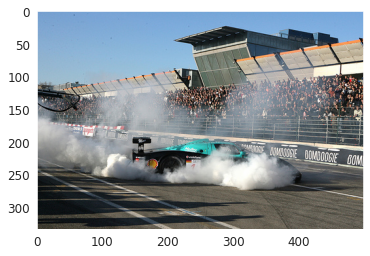

In [95]:
img = mpimg.imread('/kaggle/input/flicker8k-2k/Flickr8k_2k/Flicker8k_2kDataset/3094568845_d0b56c5651.jpg')
 
# Output Images
plt.imshow(img)

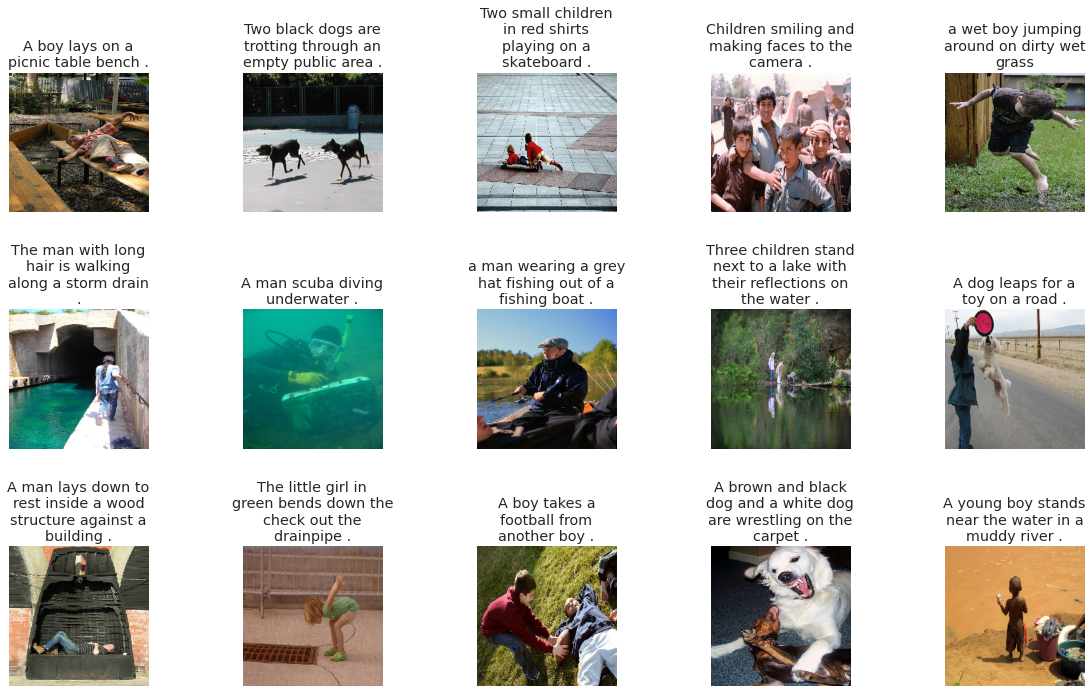

In [96]:
display_images(data.sample(15))

# **Caption Text Preprocessing Steps**
- Convert sentences into lowercase
- Remove special characters and numbers present in the text
- Remove extra spaces
- Remove single characters
- Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

<img src='http://zjpnrm2br14wspo448nls17u-wpengine.netdna-ssl.com/wp-content/uploads/2020/09/processing-steps.png' >

In [97]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

## __Preprocessed Text__

In [98]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [99]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 15, 356, 53, 183, 155, 2]

In [100]:
model = ResNet50(weights='imagenet')
fe = Model(inputs=model.input, outputs=model.layers[-2].output)
model.summary()
img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

100%|██████████| 1600/1600 [01:36<00:00, 16.61it/s]


In [101]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

# **Modelling**
- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network 
- The LSTM network starts generating words after each input thus forming a sentence at the end

<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

In [109]:
input1 = Input(shape=(2048,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [110]:
from tensorflow.keras.utils import plot_model

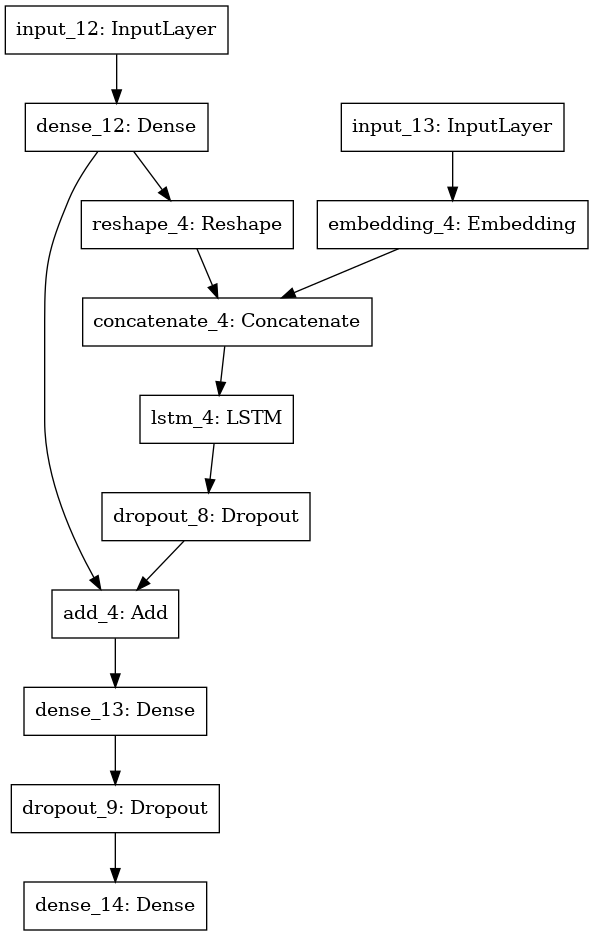

In [111]:
plot_model(caption_model)

In [112]:
caption_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 256)          524544      input_12[0][0]                   
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 31)]         0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 1, 256)       0           dense_12[0][0]                   
____________________________________________________________________________________________

In [113]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [114]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [115]:
history = caption_model.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[checkpoint,learning_rate_reduction])

Epoch 1/100
106/106 [==============================] - 36s 324ms/step - loss: 6.0405 - val_loss: 5.4392

Epoch 00001: val_loss improved from inf to 5.43915, saving model to model.h5
Epoch 2/100
106/106 [==============================] - 9s 89ms/step - loss: 5.2476 - val_loss: 4.8267

Epoch 00002: val_loss improved from 5.43915 to 4.82671, saving model to model.h5
Epoch 3/100
106/106 [==============================] - 9s 85ms/step - loss: 4.8158 - val_loss: 4.5460

Epoch 00003: val_loss improved from 4.82671 to 4.54601, saving model to model.h5
Epoch 4/100
106/106 [==============================] - 9s 83ms/step - loss: 4.5903 - val_loss: 4.4284

Epoch 00004: val_loss improved from 4.54601 to 4.42838, saving model to model.h5
Epoch 5/100
106/106 [==============================] - 10s 90ms/step - loss: 4.4490 - val_loss: 4.3905

Epoch 00005: val_loss improved from 4.42838 to 4.39051, saving model to model.h5
Epoch 6/100
106/106 [==============================] - 9s 83ms/step - loss: 4.326

# **Inference**
- Learning Curve (Loss Curve)
- Assessment of Generated Captions (by checking the relevance of the caption with respect to the image, BLEU Score )

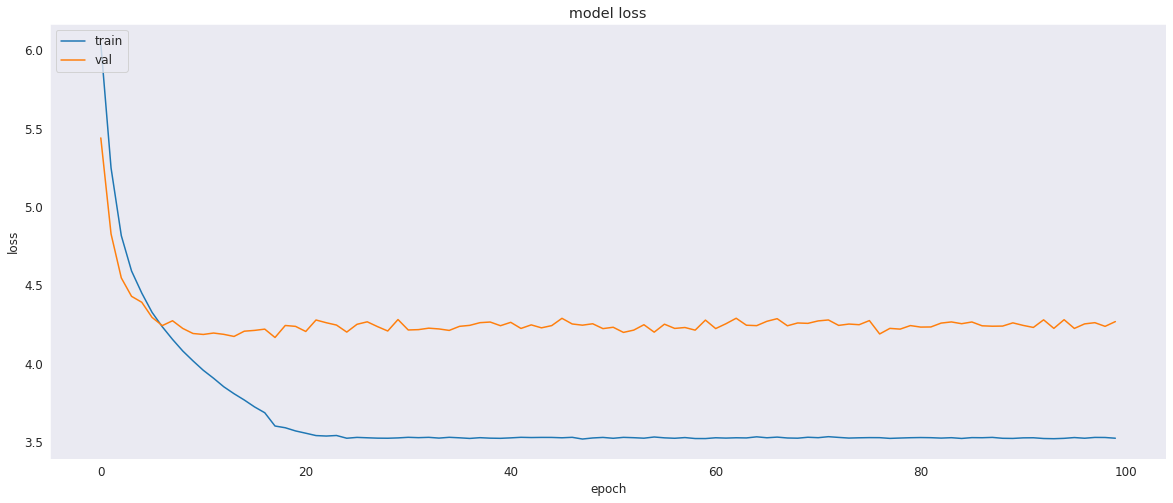

In [116]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **Caption Generation Utility Functions**
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [117]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [118]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

## **Taking 15 Random Samples for Caption Prediction**

In [119]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

In [120]:
print(len(test))

1200


In [121]:

print(test['image'])

0       2264316030_600e55748d.jpg
1       2264316030_600e55748d.jpg
2       2264316030_600e55748d.jpg
3       2264316030_600e55748d.jpg
4       2264316030_600e55748d.jpg
                  ...            
1195    2350400382_ced2b6c91e.jpg
1196    2350400382_ced2b6c91e.jpg
1197    2350400382_ced2b6c91e.jpg
1198    2350400382_ced2b6c91e.jpg
1199    2350400382_ced2b6c91e.jpg
Name: image, Length: 1200, dtype: object


In [122]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [123]:
print(samples)

                        image  \
0   2273038287_3004a72a34.jpg   
1   2314722788_6262c3aa40.jpg   
2   2282043629_91b7831352.jpg   
3   2281054343_95d6d3b882.jpg   
4   2267923837_ae88678497.jpg   
5   2276499757_b44dc6f8ce.jpg   
6   2298283771_fb21a4217e.jpg   
7   2294688426_96c8614f1d.jpg   
8   2277081067_d2b4c98bce.jpg   
9   2308256827_3c0a7d514d.jpg   
10  2311690895_0d6efe11c8.jpg   
11  2331510788_986809bbb4.jpg   
12  2344699642_4fae2f4e07.jpg   
13  2327088022_478dbd2c17.jpg   
14  2273591668_069dcb4641.jpg   

                                              caption  
0         startseq black dog running very fast endseq  
1   startseq two dogs confront each other in the m...  
2   startseq man and woman pose in the snow with f...  
3   startseq silhouette of man in hat on busy city...  
4                       startseq four children endseq  
5   startseq small black dog looks at larger brown...  
6   startseq four people in dark clothes walk in t...  
7   startseq the man in

In [124]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

# **Results**
- As we can clearly see there is some redundant caption generation e.g. Dog running through the water, overusage of blue shirt for any other coloured cloth
- The model performance can be further improved by training on more data and using attention mechanism so that our model can focus on relevant areas during the text generation
- We can also leverage the interprettability of the attention mechanism to understand which areas of the image leads to the generation of which word

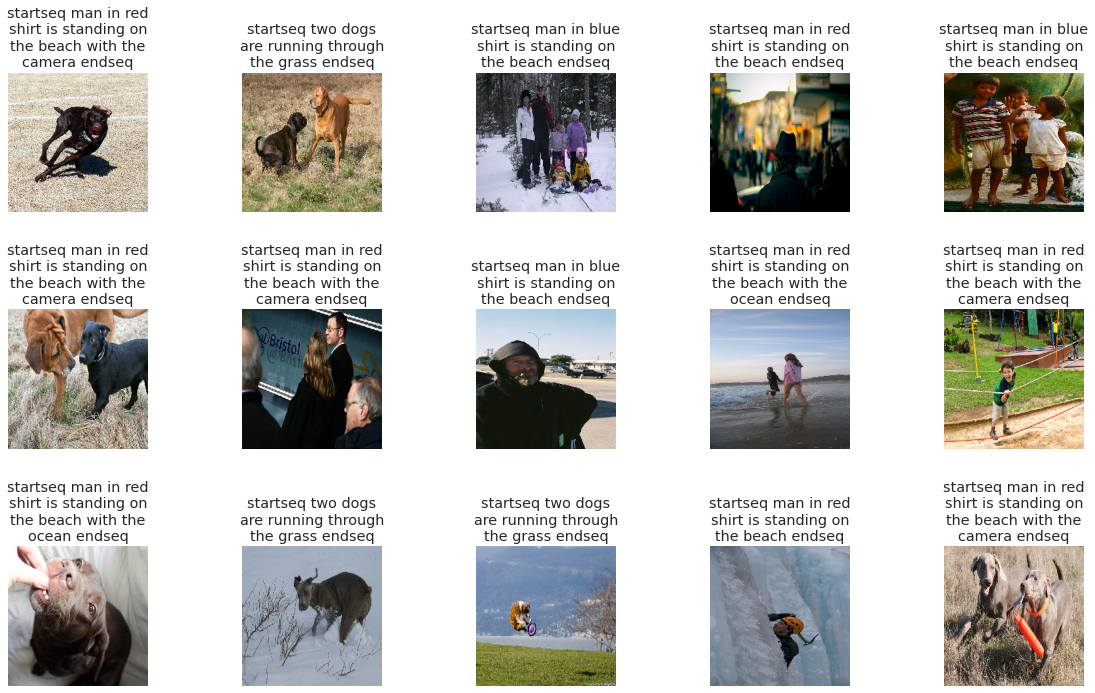

In [125]:
display_images(samples)

<p style='font-size: 18px'><strong>Conclusion: </strong>This may not be the best performing model, but the objective of this kernel is to give a gist of how Image Captioning problems can be approached. In the future work of this kernel <strong>Attention model</strong> training and <strong>BLEU Score</strong> assessment will be performed.</p>

In [126]:
import nltk
from nltk.translate.bleu_score import sentence_bleu



In [127]:
# Reference captions
ref_captions = ['A person is walking on a beach', 'A couple is watching the sunset', 'A dog is playing with a frisbee']

# Generated caption
gen_caption = 'A person is walking on a beach'

# Calculate BLEU score
bleu_score = 0
for ref_caption in ref_captions:
    reference = ref_caption[0].split() # convert reference caption to list of words
    candidate = gen_caption.split() # convert generated caption to list of words
    bleu_score += sentence_bleu([reference], candidate)

bleu_score /= len(ref_captions) # average the BLEU score over all reference captions

print('BLEU score:', bleu_score)

BLEU score: 0.6147881529512643


In [128]:
print(test)

                          image  \
0     2264316030_600e55748d.jpg   
1     2264316030_600e55748d.jpg   
2     2264316030_600e55748d.jpg   
3     2264316030_600e55748d.jpg   
4     2264316030_600e55748d.jpg   
...                         ...   
1195  2350400382_ced2b6c91e.jpg   
1196  2350400382_ced2b6c91e.jpg   
1197  2350400382_ced2b6c91e.jpg   
1198  2350400382_ced2b6c91e.jpg   
1199  2350400382_ced2b6c91e.jpg   

                                                caption  
0     startseq brown and black dog walks in the snow...  
1     startseq brown and black dog walks in the whit...  
2     startseq brown dog is running through snowy wo...  
3     startseq dog runs around in the snowy woods en...  
4     startseq dog with its tongue out walking in th...  
...                                                 ...  
1195  startseq black dog caught in mid-jump catching...  
1196  startseq black dog flies through the air while...  
1197  startseq black dog jumps in the air to catch t...  

In [129]:
bleu=[]
for index,record in test.iterrows():
    ref_captions=[]
    if(index%5==0):
        img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
        img = img_to_array(img)
        img = img/255.
        
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    bleu_score = 0
    for ref_caption in ref_captions:
        print(ref_caption)
#         reference = ref_caption.split() # convert reference caption to list of words
#         candidate = gen_caption.split() # convert generated caption to list of words
        bleu_score += sentence_bleu([reference], candidate)

#     bleu_score /= len(ref_captions)
#     print(bleu_score)
    samples.loc[index,'caption'] = caption

In [130]:
ref_captions=[]
caption_for_an_image=[]
for index,record in test.iterrows():
    if(index%5==0):
        caption_for_an_image=[]
    caption_for_an_image.append(test['caption'][index])
    if(index%5==4):
        ref_captions.append(caption_for_an_image)
print(ref_captions[0])

['startseq brown and black dog walks in the snow with its tongue hanging out endseq', 'startseq brown and black dog walks in the white snow endseq', 'startseq brown dog is running through snowy woodland endseq', 'startseq dog runs around in the snowy woods endseq', 'startseq dog with its tongue out walking in the snow endseq']


In [131]:

bleu=[]
test_captions=[]
for index,record in test.iterrows():
    
    print(index)
    test_captions.append(record['caption'].split())
    if(index%5==4):
        img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
        img = img_to_array(img)
        img = img/255.
        bleu_score = 0
        caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
        print("Generated caption: ",caption)
        
        reference = test_captions
        candidate = caption.split()
        bleu_score = sentence_bleu(reference, candidate)
#         for ref_caption in test_captions:
#             print(ref_caption)
#             reference = ref_caption.split() # convert reference caption to list of words
#             candidate = caption.split() # convert generated caption to list of words
#             print("REFERENCE: ",reference)
#             print("CANDIDATE: ",candidate)
#             bleu_score += sentence_bleu(reference, candidate)
        print(bleu_score)
#         bleu_score /= 5
        bleu.append(bleu_score)
        print(bleu_score)
        test_captions=[]
    
    
    bleu_score = 0
#     for ref_caption in test_captions:
#         print(ref_caption)
#         reference = ref_caption[0].split() # convert reference caption to list of words
#         candidate = gen_caption.split() # convert generated caption to list of words
#         bleu_score += sentence_bleu([reference], candidate)

#     bleu_score /= len(ref_captions)
#     bleu.append(bleu_score)
#     print(bleu_score)
print(bleu)

0
1
2
3
4
Generated caption:  startseq man in red shirt is standing on the beach endseq
0.8210967436686386
0.8210967436686386
5
6
7
8
9
Generated caption:  startseq man in blue shirt is standing on the beach endseq
0.4832697830906221
0.4832697830906221
10
11
12
13
14
Generated caption:  startseq man in red shirt is standing on the beach endseq
0.33180774028439425
0.33180774028439425
15
16
17
18
19
Generated caption:  startseq two dogs are running through the grass endseq
0.5133450480401704
0.5133450480401704
20
21
22
23
24
Generated caption:  startseq man in blue shirt is standing on the beach with the camera endseq
0.42610827239170174
0.42610827239170174
25
26
27
28
29
Generated caption:  startseq man in red shirt is standing on the beach endseq
0.5022573937283119
0.5022573937283119
30
31
32
33
34
Generated caption:  startseq two dogs are running through the grass endseq
0.7598356856515925
0.7598356856515925
35
36
37
38
39
Generated caption:  startseq man in red shirt is standing on t

In [132]:
print('Min BLEU value: ',min(bleu))

Min BLEU value:  0.19694347419590436


In [133]:
print('Max BLEU value: ',max(bleu))

Max BLEU value:  0.8931539818068694


In [134]:
mean_bleu=sum(bleu)/len(bleu)
print('Mean BLEU value: ',round(mean_bleu,2))

Mean BLEU value:  0.61


In [135]:
import nltk.translate.bleu_score as bleu

samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

bleu_scores = []

for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption
    
    # reference captions for the image
    references = [ref_caption.split() for ref_caption in record['caption']]
    
    # candidate caption generated by the model
    candidate = caption.split()
    
    # calculate BLEU score
    bleu_score = bleu.sentence_bleu(references, candidate)
    bleu_scores.append(bleu_score)
    
    print("BLEU score for image {}: {}".format(record['image'], bleu_score))
    
print("Average BLEU score: {}".format(sum(bleu_scores)/len(bleu_scores)))

BLEU score for image 2269795781_46a296aa21.jpg: 0
BLEU score for image 226607225_44d696db6b.jpg: 0
BLEU score for image 2310233145_910cb5b4c8.jpg: 0
BLEU score for image 2322601965_748d59dc57.jpg: 0
BLEU score for image 2289212650_69de7a20b2.jpg: 0
BLEU score for image 2326730558_75c20e5033.jpg: 0
BLEU score for image 2271264741_aa8f73f87c.jpg: 0
BLEU score for image 2335634931_7e9e8c2959.jpg: 0
BLEU score for image 2276499757_b44dc6f8ce.jpg: 0
BLEU score for image 2273871383_1ddb3562ea.jpg: 0
BLEU score for image 2298077331_f9a1488067.jpg: 0
BLEU score for image 2308271254_27fb466eb4.jpg: 0
BLEU score for image 2291485126_b8d41a63f4.jpg: 0
BLEU score for image 2266142543_b2de18c081.jpg: 0
BLEU score for image 2328106090_b7c2725501.jpg: 0
Average BLEU score: 0.0
